In [1]:
# Reading in data
import pandas as pd
from pathlib import Path
import re

# Import plot libraries
import matplotlib as mpl
import matplotlib.pyplot as pp
from matplotlib import rc
%matplotlib inline
import seaborn as sb
sb.set_palette('CMRmap_r')

# Set custom design for plots
%matplotlib inline
IPython_default = pp.rcParams.copy()
from matplotlib import rc, cycler
colors = cycler('color',
                ['#EE6666', # bright red
                 '#66EEEE', # bright blue
                 '#941111', # dark red
                 '#022869', # dark blue
                 '#9988DD', # purple
                 '#88BB44']) # green

mpl.rcParams['font.family'] = 'Arial'
params = {'figure.figsize': (14, 12),
         'axes.labelsize': 22,
         'axes.titlesize': 32,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'legend.fontsize': 20,
         'legend.title_fontsize': 'x-large',
         'axes.facecolor': '#FFFFFF',
         'axes.axisbelow': 'True',
         'axes.grid': 'False',
         'axes.prop_cycle': colors,
         'lines.linewidth': 2}
mpl.rcParams.update(params)

# Statistics libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

In [2]:
data = pd.read_excel(Path('F.vesca_phytohormone_daylength_data.xlsx'))

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Zeitgeber,440.0,28.254545,14.699069,0.000000,16.000000,32.000000,40.000000,48.000000
Replicate,440.0,1.995455,0.818342,1.000000,1.000000,2.000000,3.000000,3.000000
IAA,440.0,69.339953,46.958448,2.733853,43.095052,67.272551,91.779358,252.383104
COOH-JA-Ile,440.0,22.031280,17.962168,2.793299,10.430962,16.823416,25.932991,115.396434
OH-JA-Ile,440.0,35.927502,29.223416,5.263429,17.438658,26.717412,43.878281,220.958441
OH-JA,440.0,3461.705777,7175.222780,482.505821,1145.734276,1831.349178,3163.599747,59215.473817
cis-OPDA,440.0,4536.480252,6555.766843,100.307398,978.105560,2203.690975,5272.448706,54976.029946
sum JA-Ile,440.0,36.592457,41.731930,1.428449,11.305808,22.581599,43.119448,315.819560
ABA,440.0,266.799671,322.155242,28.769482,52.744540,100.695986,539.156146,1268.419519
JA,440.0,200.146027,215.923634,30.899017,93.580225,139.047684,208.697133,2084.757581


In [4]:
data.head()

,Sample_ID,Clone,Zeitgeber,Clock_time,Light,Treatment,Replicate,IAA,COOH-JA-Ile,OH-JA-Ile,OH-JA,cis-OPDA,sum JA-Ile,ABA,JA,SA
0,I1_1A,I1,0,08:00,Light,Norway,1,65.784102,24.031964,39.252254,3545.505413,3084.591490,20.036184,558.390835,182.121607,5130.962584
1,I1_1A,I1,0,08:00,Light,Norway,2,56.268715,9.123972,24.336734,3792.681717,2020.483062,17.635381,616.730562,155.145338,7014.271891
2,I1_1A,I1,0,08:00,Light,Norway,3,54.042476,8.383689,20.583411,3699.796939,9591.348682,11.300384,593.725490,108.701654,5626.867859
3,I1_2A,I1,4,12:00,Light,Norway,1,100.230783,28.380698,64.077387,2390.731481,10555.829092,43.462398,792.995170,1113.024397,8881.709590
4,I1_2A,I1,4,12:00,Light,Norway,2,75.929766,18.646311,33.666951,1817.694564,2475.014021,14.745220,585.504876,418.499732,6637.678774


In [5]:
data_melt = pd.melt(frame = data, 
                    id_vars = ['Sample_ID', 'Clone', 'Zeitgeber', 'Clock_time', 'Treatment', 'Replicate', 'Light'], 
                    var_name='Hormone', 
                    value_name = 'Value')
data_melt.head()

,Sample_ID,Clone,Zeitgeber,Clock_time,Treatment,Replicate,Light,Hormone,Value
0,I1_1A,I1,0,08:00,Norway,1,Light,IAA,65.784102
1,I1_1A,I1,0,08:00,Norway,2,Light,IAA,56.268715
2,I1_1A,I1,0,08:00,Norway,3,Light,IAA,54.042476
3,I1_2A,I1,4,12:00,Norway,1,Light,IAA,100.230783
4,I1_2A,I1,4,12:00,Norway,2,Light,IAA,75.929766


In [6]:
def locate_outlier_IQR(df):
    Q1=df['Value'].quantile(0.25)
    Q3=df['Value'].quantile(0.75)
    IQR=Q3-Q1
    low = Q1-1.5*IQR
    high = Q3+1.5*IQR
    new_df = df.loc[(df['Value'] > low) & (df['Value'] < high)]
    return (new_df)

In [7]:
def h_data(df, hormone):
    
    h_data = df.loc[df.Hormone == hormone]
    h_data = locate_outlier_IQR(h_data)
    return(h_data)

In [8]:
JA = h_data(data_melt, 'JA')
JA_Ile = h_data(data_melt, 'sum JA-Ile')
ABA = h_data(data_melt, 'ABA')
IAA = h_data(data_melt, 'IAA')

## Other hormones are degredation products.
## e.g. cis-OPDA, SA are rarely different.

In [9]:
def kruskal_wallis(df):
    print('Are the residuals normally distributed?') 
    print(stats.shapiro(df['Value'])) 
    print(' ')
    print('Light vs. Dark')
    print(stats.kruskal(df['Light'] == 'Light', df['Light'] == 'Dark'))
    print('Norway vs. Italy')
    print(stats.kruskal(df['Treatment'] == 'Norway', df['Treatment'] == 'Italy'))
    print('Norway vs. Dark')
    print(stats.kruskal(df['Treatment'] == 'Norway', df['Treatment'] == 'D-Norway'))
    print('Italy vs. Dark')
    print(stats.kruskal(df['Treatment'] == 'Italy', df['Treatment'] == 'D-Italy'))

## Jasmonic acid (JA)

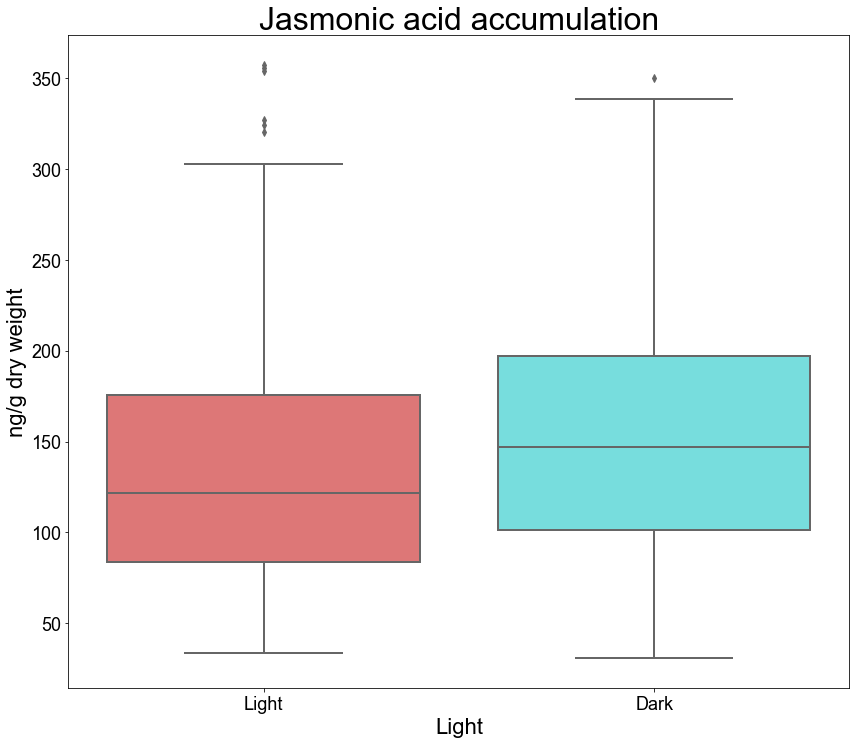

In [10]:
sb.boxplot(x = 'Light', y = 'Value', data = JA)
pp.title('Jasmonic acid accumulation')
pp.ylabel('ng/g dry weight')
pp.savefig("JA_accumulation.png", dpi=300)
pp.show()

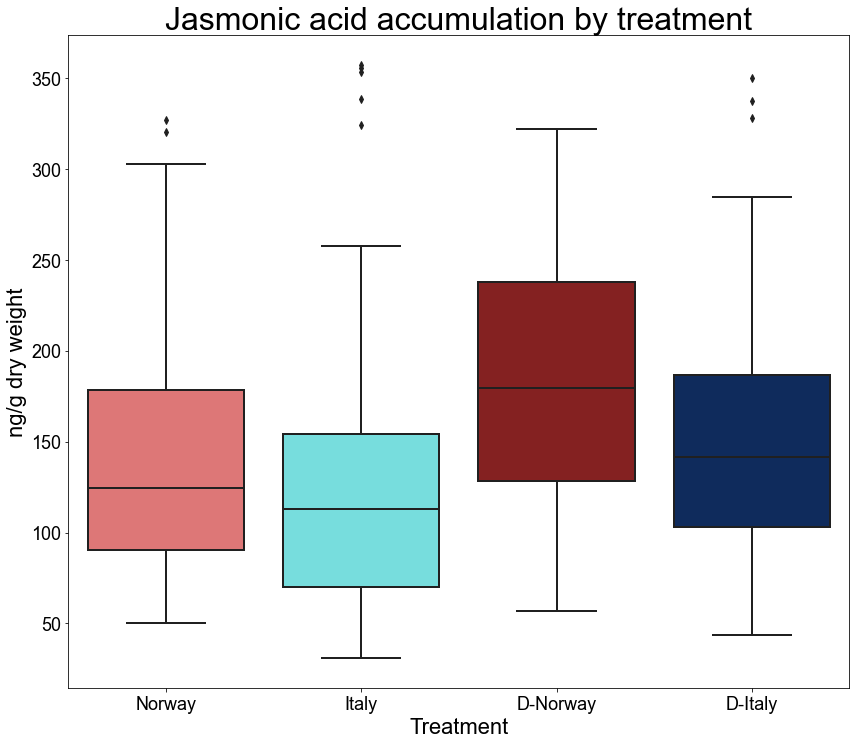

In [11]:
sb.boxplot(x = 'Treatment', y = 'Value', data = JA)
pp.title('Jasmonic acid accumulation by treatment')
pp.ylabel('ng/g dry weight')
pp.savefig("JA_treatment_accumulation.png", dpi=300)
pp.show()

In [26]:
stats.kruskal(JA['Treatment'] == 'Norway', JA['Treatment'] == 'Italy', JA['Treatment'] == 'D-Norway', JA['Treatment'] == 'D-Italy')

KruskalResult(statistic=62.741134483136726, pvalue=1.525512009020928e-13)

In [12]:
kruskal_wallis(JA)

Are the residuals normally distributed?
ShapiroResult(statistic=0.9437776803970337, pvalue=3.855826422038966e-11)
 
Light vs. Dark
KruskalResult(statistic=16.883285775611842, pvalue=3.975007096503816e-05)
Norway vs. Italy
KruskalResult(statistic=0.005628597523777139, pvalue=0.9401956326481535)
Norway vs. Dark
KruskalResult(statistic=37.27626125971884, pvalue=1.0252502940702959e-09)
Italy vs. Dark
KruskalResult(statistic=25.30455087440409, pvalue=4.895523522826104e-07)


# Jasmonic acid Isoleucine conjugate (JA-Ile)

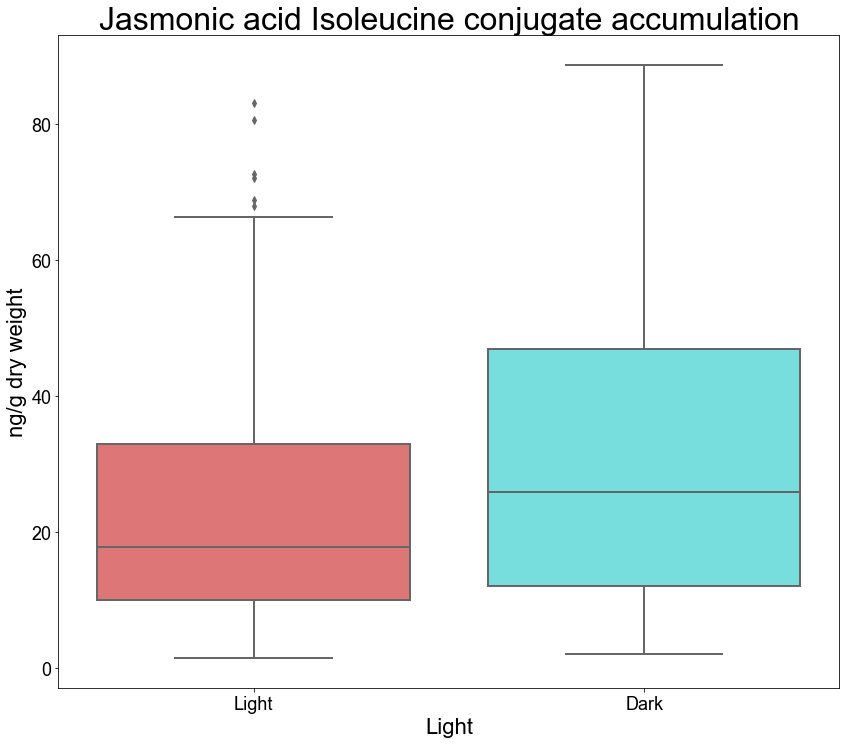

In [13]:
sb.boxplot(x = 'Light', y = 'Value', data = JA_Ile)
pp.title('Jasmonic acid Isoleucine conjugate accumulation')
pp.ylabel('ng/g dry weight')
pp.savefig("JA_Ile_accumulation.png", dpi=300)
pp.show()

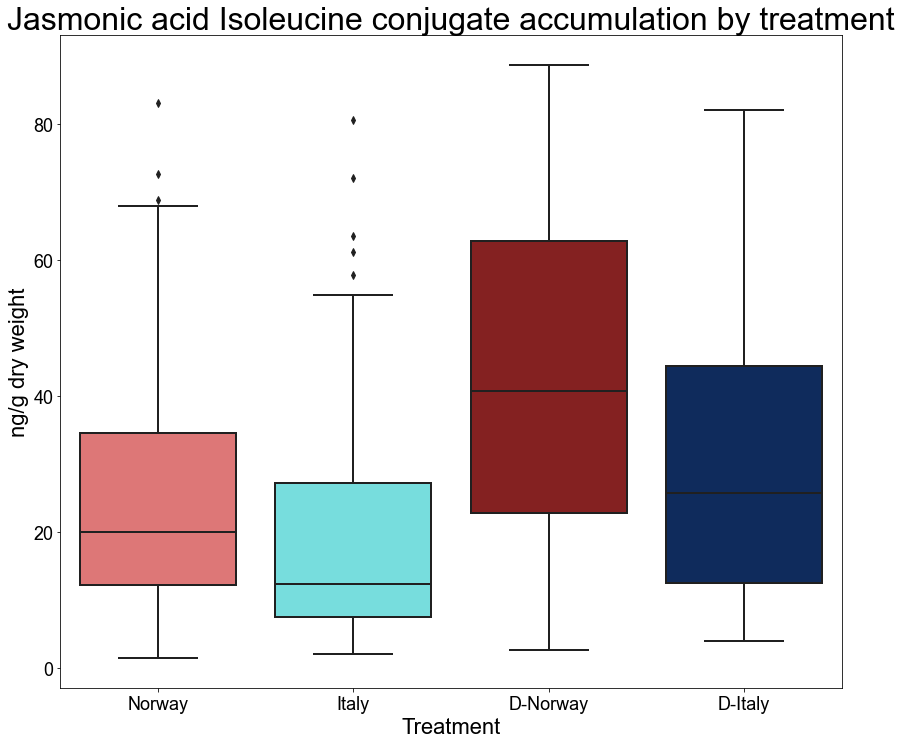

In [14]:
sb.boxplot(x = 'Treatment', y = 'Value', data = JA_Ile)
pp.title('Jasmonic acid Isoleucine conjugate accumulation by treatment')
pp.ylabel('ng/g dry weight')
pp.savefig("JA_Ile_treatment_accumulation.png", dpi=300)
pp.show()

In [25]:
stats.kruskal(JA_Ile['Treatment'] == 'Norway', JA_Ile['Treatment'] == 'Italy', JA_Ile['Treatment'] == 'D-Norway', JA_Ile['Treatment'] == 'D-Italy')

KruskalResult(statistic=82.44784026825145, pvalue=9.159747978976857e-18)

In [15]:
kruskal_wallis(JA_Ile)

Are the residuals normally distributed?
ShapiroResult(statistic=0.8837609887123108, pvalue=6.272200888568269e-17)
 
Light vs. Dark
KruskalResult(statistic=39.06775796372491, pvalue=4.0934873816487247e-10)
Norway vs. Italy
KruskalResult(statistic=0.9197572805737466, pvalue=0.3375387105299295)
Norway vs. Dark
KruskalResult(statistic=50.351186266315544, pvalue=1.2855236894128205e-12)
Italy vs. Dark
KruskalResult(statistic=31.677610639120307, pvalue=1.820084400129716e-08)


# Abscissic acid (ABA)

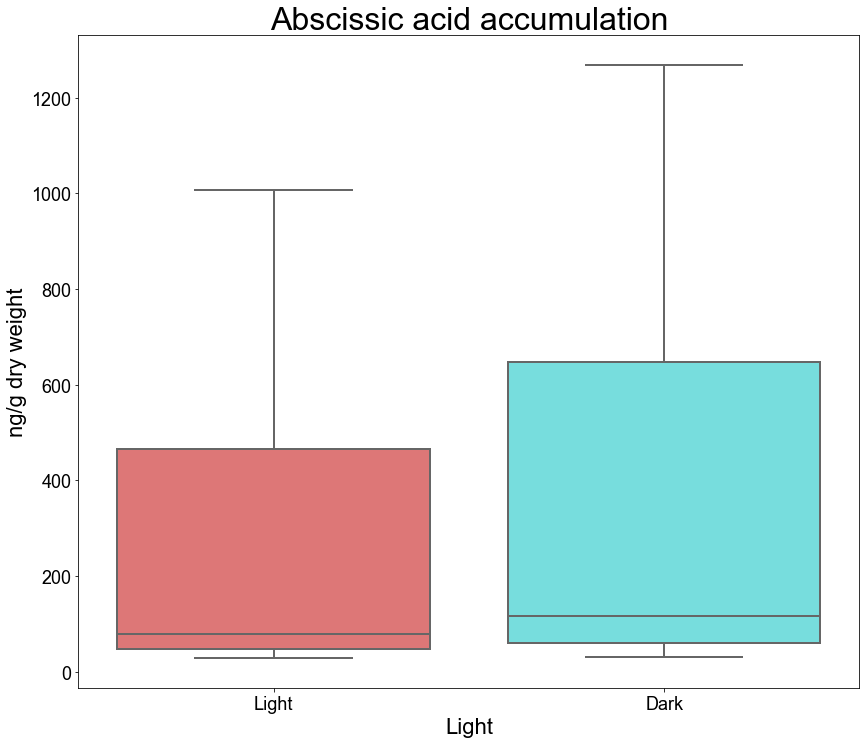

In [16]:
sb.boxplot(x = 'Light', y = 'Value', data = ABA)
pp.title('Abscissic acid accumulation')
pp.ylabel('ng/g dry weight')
pp.savefig("ABA_accumulation.png", dpi=300)
pp.show()

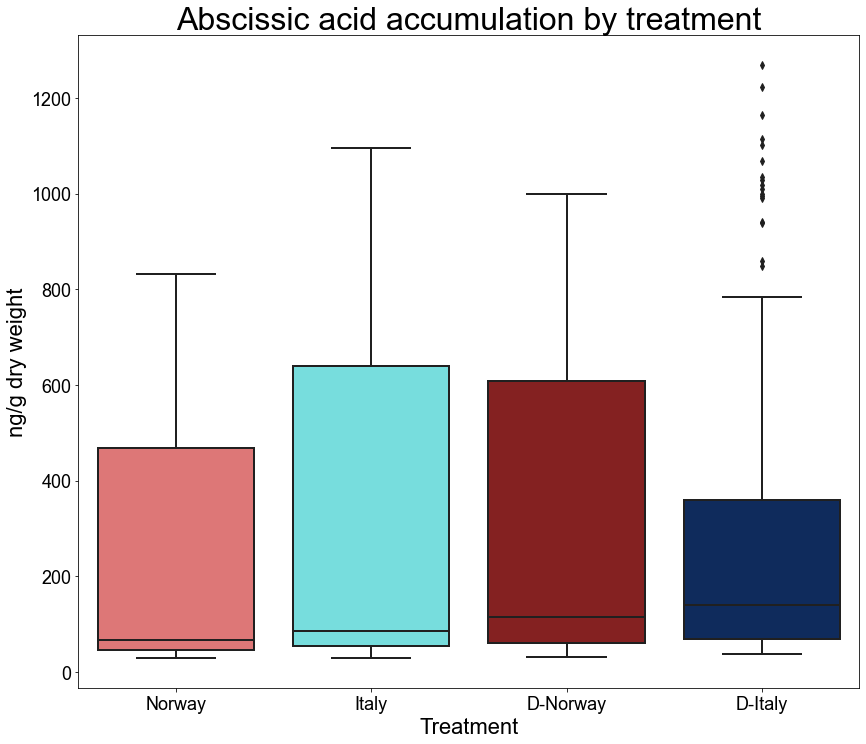

In [17]:
sb.boxplot(x = 'Treatment', y = 'Value', data = ABA)
pp.title('Abscissic acid accumulation by treatment')
pp.ylabel('ng/g dry weight')
pp.savefig("ABA_treatment_accumulation.png", dpi=300)
pp.show()

In [23]:
stats.kruskal(ABA['Treatment'] == 'Norway', ABA['Treatment'] == 'Italy', ABA['Treatment'] == 'D-Norway', ABA['Treatment'] == 'D-Italy')

KruskalResult(statistic=79.78494490358163, pvalue=3.413220668143084e-17)

In [24]:
kruskal_wallis(ABA)

Are the residuals normally distributed?
ShapiroResult(statistic=0.7028182744979858, pvalue=3.658469559338772e-27)
 
Light vs. Dark
KruskalResult(statistic=32.036280991735595, pvalue=1.5131994116855475e-08)
Norway vs. Italy
KruskalResult(statistic=0.1260909231746722, pvalue=0.7225200423903833)
Norway vs. Dark
KruskalResult(statistic=44.77330578512421, pvalue=2.2121811796220828e-11)
Italy vs. Dark
KruskalResult(statistic=34.966280991735616, pvalue=3.354646106122156e-09)


# Auxin (IAA)

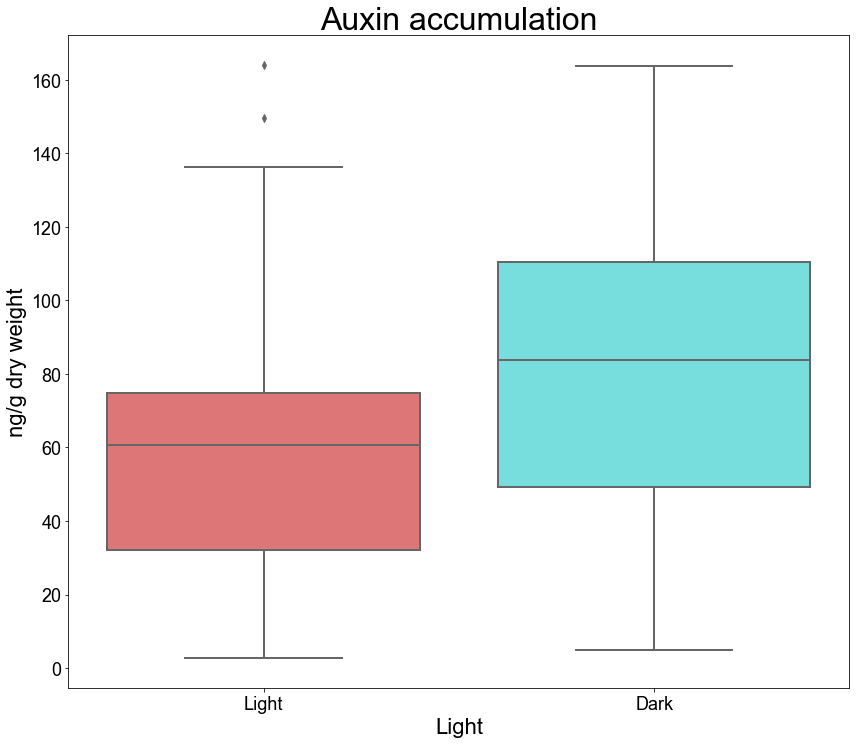

In [19]:
sb.boxplot(x = 'Light', y = 'Value', data = IAA)
pp.title('Auxin accumulation')
pp.ylabel('ng/g dry weight')
pp.savefig("IAA_accumulation.png", dpi=300)
pp.show()

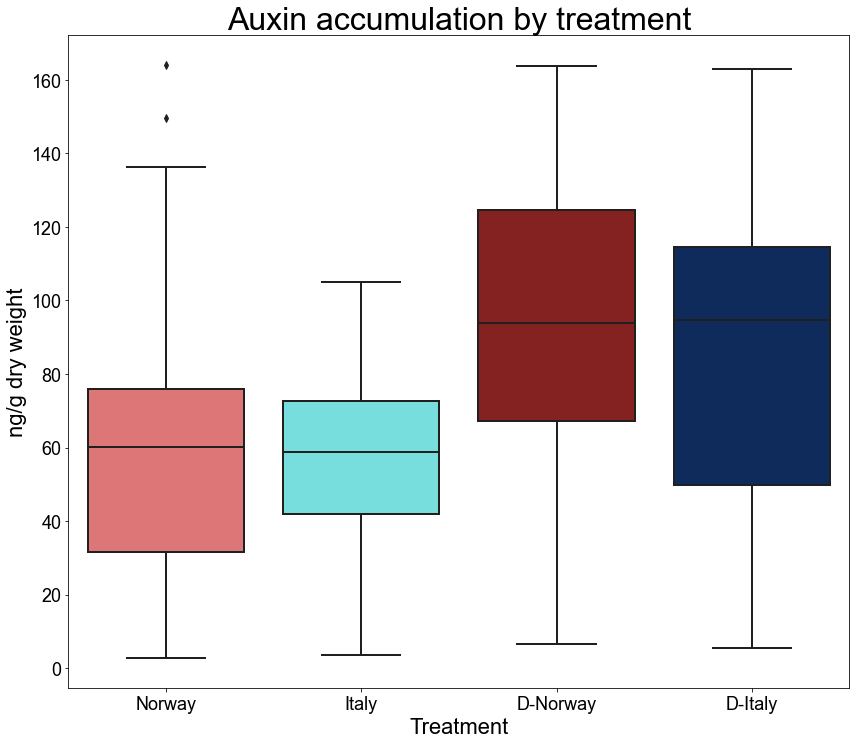

In [20]:
sb.boxplot(x = 'Treatment', y = 'Value', data = IAA)
pp.title('Auxin accumulation by treatment')
pp.ylabel('ng/g dry weight')
pp.savefig("IAA_treatment_accumulation.png", dpi=300)
pp.show()

In [22]:
stats.kruskal(IAA['Treatment'] == 'Norway', IAA['Treatment'] == 'Italy', IAA['Treatment'] == 'D-Norway', IAA['Treatment'] == 'D-Italy')

KruskalResult(statistic=104.25792564925753, pvalue=1.8870392668322768e-22)

In [21]:
kruskal_wallis(IAA)

Are the residuals normally distributed?
ShapiroResult(statistic=0.9567704796791077, pvalue=8.921768879233127e-10)
 
Light vs. Dark
KruskalResult(statistic=50.33919352745714, pvalue=1.293403777044902e-12)
Norway vs. Italy
KruskalResult(statistic=0.12911367530270085, pvalue=0.7193527863740196)
Norway vs. Dark
KruskalResult(statistic=59.81215749412305, pvalue=1.0435672488086718e-14)
Italy vs. Dark
KruskalResult(statistic=44.430188679245326, pvalue=2.6359092994987053e-11)
